# Livingston (KLVM, MTELV, MTLWM) ProbGust Comparision

Compare ProbGust and previous guidance.

## Import modules

In [1]:
import xarray            as xr
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib.dates  as mdates
import seaborn           as sns
import scipy.stats       as stats
import pint

## Set some contants

In [2]:
sns.set_theme(color_codes=True, style="darkgrid")
palette = sns.color_palette()[0:3] + [(0,0,0)]#['yellow', 'orange', 'red', 'black']
units = pint.UnitRegistry()
hour = pd.to_timedelta('1H')
normal_distribution = stats.norm()

## Define utility functions

### load_forecast_grid:
Load time series from a gridded source converting units and filtering fields. Also creates the valid time field from reference time and time since reference. Can tranform column names if needed, ie for NBM 1 hour forecast.

In [3]:
def load_forecast_grid(filename, filter_fields=None, transform_columns=None):
    data = xr.open_dataset(filename).to_dataframe()
    if transform_columns is not None:
        data.columns = data.columns.to_series().apply(transform_columns)
    data['valid_time'] = data.reference_time + data.time_since_reference * hour
    data = data.set_index(['reference_time', 'valid_time']).sort_index()
    if filter_fields is None:
        filter_fields = data.columns
    return data[filter_fields]

### convert_units
Convert units of columns in a DataFrame

In [4]:
def convert_units(data, columns):
    for col in columns.keys():
        data[col] = pint.Quantity(data[col].to_numpy(), units(columns[col][0])).to(units(columns[col][1])).magnitude

### filter_missing_data
Filter rows that are filled with NaNs, ignoring time fields by default

In [5]:
def filter_missing_data(data):
    return data.dropna(how='all')

### load_observations
Load time series from observation source, converting units and filtering fields.

In [6]:
def load_observations(filename, filter_fields=None):
    data = xr.open_dataset(filename).to_dataframe().set_index('time').sort_index()
    if filter_fields is not None:
        data = data.loc[:, filter_fields]
    return data

### replace_missing_gust_with_wind
Since that gusts for AWOS/ASOS are not reported unless the gusts is sufficiently higher than sustained wind, replace missing gust values with the sustained to compare to RTMA / NBM that always has a gust value.

In [7]:
def replace_missing_gust_with_wind(data, wind_field, wind_gust_field):
    index = np.isnan(data[wind_gust_field])
    data.loc[index, wind_gust_field] = data[wind_field][index]

### get_period_maximum
Find the maximum values when rounding the time fields to nearest time period

In [8]:
def get_period_maximum(data, period='1H'):
    return data.groupby(data.index.round(period)).max()

### generate_prob_gust
Calculate the Z-Score given the bias-corrected NBM mean wind gust and standard deviation

In [9]:
def generate_prob_gust(data, threshold, unit='mph', tollerance = 0.6, mean='10_meter_wind_speed_of_gust_mean', standard_deviation='10_meter_wind_speed_of_gust_standard_deviation'):
    threshold = pint.Quantity(threshold - tollerance, units(unit)).to(units('m s**-1')).magnitude
    z_score = pd.Series((threshold - data[mean]) / data[standard_deviation], index=data.index)
    return pd.Series(np.round((100 * normal_distribution.sf(z_score))), index=data.index)


### expand_timelag
Duplicate a dataframe while adjusting a datetime field by an interval to create a time-lagged dataset

In [10]:
def expand_timelag(df, interval, field='reference_time'):
    df2 = df.copy(deep=True).reset_index()
    df2[field] += pd.to_timedelta(interval)
    return df2

### load_operational_probability
Load the operational probability for the time-lagged wind guidance

In [11]:
def load_operational_probability():
    previous_data = xr.open_dataset('../data/database/MOSDATA.nc').to_dataframe()
    previous_data = previous_data[(previous_data.stn == 'KLVM') & (previous_data.model == 'MAV') & np.isfinite(previous_data.run) & np.isfinite(previous_data.valid) & (previous_data.valid >= pd.to_datetime('2020-09-30T18:00:00Z').to_datetime64())][['run', 'valid', 'WDR', 'WSP']].set_index(['run', 'valid']).sort_index()

    subadvisory_matrix = xr.open_dataset('../data/database/LVMSubmatrix_MAV.nc').to_dataframe()
    advisory_matrix = xr.open_dataset('../data/database/LVMmatrix.nc').to_dataframe()
    warning_matrix = xr.open_dataset('../data/database/LVMWarnmatrix.nc').to_dataframe()

    previous_data['MaxSub'] = pd.merge(right=previous_data.reset_index(), left=subadvisory_matrix.groupby(['WindDirection']).WindSpeed.max().reset_index(), right_on='WDR', left_on='WindDirection', how='right').set_index(['run', 'valid']).sort_index()['WindSpeed']
    previous_data.MaxSub= previous_data.MaxSub.fillna(999)

    previous_data['MaxAdv'] = pd.merge(right=previous_data.reset_index(), left=advisory_matrix.groupby(['WindDirection']).WindSpeed.max().reset_index(), right_on='WDR', left_on='WindDirection', how='right').set_index(['run', 'valid']).sort_index()['WindSpeed']
    previous_data.MaxAdv = previous_data.MaxAdv.fillna(999)

    previous_data['MaxWarn'] = pd.merge(right=previous_data.reset_index(), left=warning_matrix.groupby(['DIR']).WS.max().reset_index(), right_on='WDR', left_on='DIR', how='right').set_index(['run', 'valid']).sort_index()['WS']
    previous_data.MaxWarn = previous_data.MaxWarn.fillna(999)

    previous_data['SubSpeed'] = previous_data[['WSP', 'MaxSub']].apply(lambda a: a.min(), axis=1)
    previous_data['Raw_50'] = pd.merge(right=previous_data.reset_index(), left=subadvisory_matrix, right_on=['WDR', 'SubSpeed'], left_on=['WindDirection', 'WindSpeed'], how='right').groupby(['run', 'valid'])['Probability'].max()
    previous_data.Raw_50 = previous_data.Raw_50.fillna(0)

    previous_data['AdvSpeed'] = previous_data[['WSP', 'MaxAdv']].apply(lambda a: a.min(), axis=1)
    previous_data['Raw_58'] = pd.merge(right=previous_data.reset_index(), left=advisory_matrix, right_on=['WDR', 'AdvSpeed'], left_on=['WindDirection', 'WindSpeed'], how='right').groupby(['run', 'valid'])['Probability'].max()
    previous_data.Raw_58 = previous_data.Raw_58.fillna(0)

    previous_data['WarnSpeed'] = previous_data[['WSP', 'MaxWarn']].apply(lambda a: a.min(), axis=1)
    previous_data['Raw_75'] = pd.merge(right=previous_data.reset_index(), left=warning_matrix, right_on=['WDR', 'WarnSpeed'], left_on=['DIR', 'WS'], how='right').groupby(['run', 'valid'])['Prob'].max()
    previous_data.Raw_75 = previous_data.Raw_75.fillna(0)

    previous_data = previous_data.reset_index()[['run', 'valid', 'Raw_50', 'Raw_58', 'Raw_75']]
    previous_data.columns = ['reference_time', 'valid_time', 'Raw_50', 'Raw_58', 'Raw_75']
    previous_data = previous_data.set_index(['reference_time', 'valid_time']).sort_index()

    previous_data[[x.replace('Raw', 'Operational') for x in ['Raw_50', 'Raw_58', 'Raw_75']]] = pd.concat([expand_timelag(previous_data, '{0:d}H'.format(i*6)) for i in range(12)]).groupby(['reference_time', 'valid_time']).mean()[['Raw_50', 'Raw_58', 'Raw_75']]
    return previous_data[[x for x in previous_data.columns if x.find('Operational_') > -1]]

### load_nbm_prob_gust
apply bias-correction and calculate ProbGust

In [12]:
def load_nbm_prob_gust(siteID, regression, thresholds, mean='10_meter_wind_speed_of_gust_mean', spread='10_meter_wind_speed_of_gust_standard_deviation'):
    nbm_data = load_forecast_grid('../data/nbm/NBM_{0:s}.nc'.format(siteID), filter_fields=[mean, spread])
    nbm_data = filter_missing_data(nbm_data)
    nbm_data[mean] = regression.slope[siteID] * nbm_data[mean] + regression.intercept[siteID]
    for threshold in thresholds:
        nbm_data['ProbGust_{0:d}'.format(threshold)] = generate_prob_gust(nbm_data, threshold)
    return nbm_data[[col for col in nbm_data.columns if col.find('ProbGust') > -1]]

### load_wind_gust_observation
load the wind gust, optionally filling with wind speed if gust is missing and applying a correction

In [13]:
def load_wind_gust_observation(siteID, wind_speed='10_meter_wind_speed', wind_gust='10_meter_wind_speed_of_gust', correction=None):
    obs_data = load_observations('../data/observations/{0:s}.nc'.format(siteID), 
                                 filter_fields=[x for x in [wind_speed, wind_gust] if x is not None])
    if wind_speed is not None:
        replace_missing_gust_with_wind(obs_data, wind_speed, wind_gust)
    obs_data = obs_data[[wind_gust]].reset_index().set_index('time')
    if correction is not None:
        obs_data = correction(obs_data)
    return filter_missing_data(obs_data)

## Read Bias-Correction parameters

In [14]:
regression = pd.read_json('../data/derived/regressions.json', orient='table')
regression

,slope,intercept,rvalue,pvalue,stderr
MTELV,0.893859,6.923222,0.703279,1.471382e-186,0.025618
LVM,1.022861,4.676071,0.796859,0.000000e+00,0.018798
MTLWM,0.894840,7.826072,0.683627,2.977567e-138,0.030286
6S0,0.796994,8.129035,0.685876,3.758471e-201,0.022276
1KM,0.715568,8.136230,0.735165,1.881445e-130,0.023934
UMHM,0.695138,9.328585,0.715288,1.233256e-229,0.017768


## Load Observaions
Load hourly max wind gust from KLVM, MTELV, and MTLWM 

In [15]:
obs = get_period_maximum(pd.concat([ load_wind_gust_observation(x) for x in ['MTLWM', 'MTELV', 'LVM']]).sort_values(['time']).groupby(['time']).max(), period='1H').reset_index()
obs.columns = ['valid_time', 'Verification_Gust']
obs = obs.set_index('valid_time')
convert_units(obs, dict([(x, ('m/s','mph')) for x in obs.columns]))
obs

,Verification_Gust
valid_time,
2020-05-18 00:00:00,11.507794
2020-05-18 01:00:00,13.809353
2020-05-18 02:00:00,2.301559
2020-05-18 03:00:00,10.357015
2020-05-18 04:00:00,10.357015
...,...
2021-05-01 02:00:00,14.316392
2021-05-01 03:00:00,9.887258
2021-05-01 04:00:00,12.392627


## Load NBM forecast
Calculate the hourly maximum ProbGust for each threshold from KLVM, MTELV, and MTLWM

In [16]:
nbm = pd.concat([load_nbm_prob_gust(x, regression, [50, 58, 75]).reset_index() for x in ['MTLWM', 'MTELV', 'LVM']]).groupby(['reference_time', 'valid_time']).max().reset_index()
nbm.reference_time -= 9*hour
nbm = nbm.set_index(['reference_time', 'valid_time']).sort_index()

nbm

ProbGust_50  ProbGust_58  ProbGust_75
reference_time valid_time                                                
2020-10-01     2020-10-01 10:00:00          0.0          0.0          0.0
               2020-10-01 11:00:00          0.0          0.0          0.0
               2020-10-01 12:00:00          0.0          0.0          0.0
               2020-10-01 13:00:00          0.0          0.0          0.0
               2020-10-01 14:00:00          0.0          0.0          0.0
...                                         ...          ...          ...
2021-03-27     2021-04-02 21:00:00          0.0          0.0          0.0
               2021-04-03 00:00:00          0.0          0.0          0.0
               2021-04-03 03:00:00          0.0          0.0          0.0
               2021-04-03 06:00:00          1.0          0.0          0.0
               2021-04-03 09:00:00          0.0          0.0          0.0

[23997 rows x 3 columns]

## Time-match and Pivot Observations, NBM, and Operational Guidance

In [17]:
data = pd.merge(left=pd.merge(left=nbm, right=load_operational_probability(), left_index=True, right_index=True, how='left'), right=obs, left_index=True, right_index=True, how='outer')#.reset_index().melt(id_vars=['reference_time', 'valid_time'], var_name='Model', value_name='Probability').set_index(['reference_time', 'valid_time'])
data[[x.replace('ProbGust', 'Verification') for x in data.columns if x.find('ProbGust_') > -1]] = [int(x.replace('ProbGust_', '')) for x in data.columns if x.find('ProbGust_') > -1]
data = data.reset_index().melt(id_vars=['reference_time', 'valid_time'], var_name='Model', value_name='Probability').set_index(['reference_time', 'valid_time'])
data

Model  Probability
reference_time valid_time                                       
2020-10-01     2020-10-01 10:00:00      ProbGust_50          0.0
               2020-10-01 11:00:00      ProbGust_50          0.0
               2020-10-01 12:00:00      ProbGust_50          0.0
               2020-10-01 13:00:00      ProbGust_50          0.0
               2020-10-01 14:00:00      ProbGust_50          0.0
...                                             ...          ...
2021-03-27     2021-04-02 21:00:00  Verification_75         75.0
               2021-04-03 00:00:00  Verification_75         75.0
               2021-04-03 03:00:00  Verification_75         75.0
               2021-04-03 06:00:00  Verification_75         75.0
               2021-04-03 09:00:00  Verification_75         75.0

[239970 rows x 2 columns]

## Plot Comparision Chart for an NBM Run

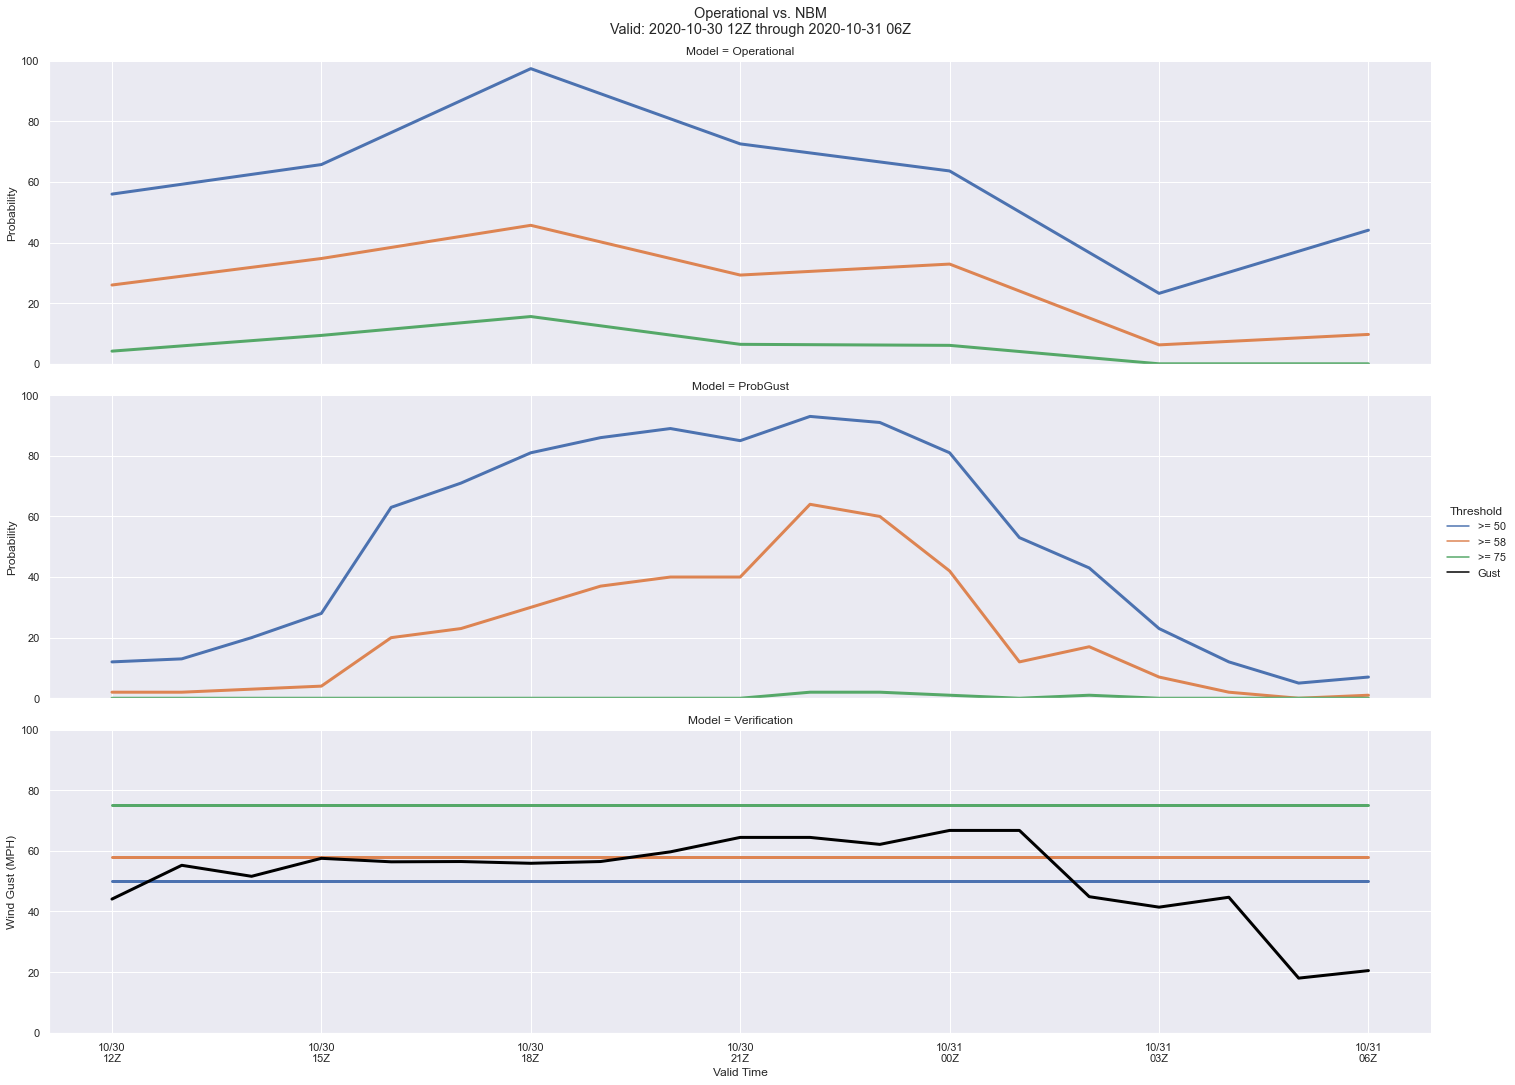

In [19]:
event_begin = pd.to_datetime('2020-10-30T12:00:00Z')
event_end   = pd.to_datetime('2020-10-31T06:00:00Z')

output_file = event_begin.strftime('output/events/Livingston_%Y%m%d%H.png')

run = pd.concat([data[(data.index.get_level_values(0) == (event_begin + 12 * hour * (i-1) - (hour * (event_begin.hour % 12))).to_datetime64()) * (data.index.get_level_values(1) <= (event_begin + 12 * hour * (i-1) + pd.to_timedelta('3D')).to_datetime64())].reset_index()  for i in range(int(((event_end - event_begin).total_seconds()/3600)//12+2))])
run = pd.merge(left=run.groupby(['valid_time', 'Model']).max().reference_time.reset_index(),
                right=run, left_on=['reference_time', 'valid_time', 'Model'], right_on=['reference_time', 'valid_time', 'Model'], how='inner')[[x for x in run.columns if x != 'reference_time']]
run = run[(event_begin.to_datetime64() <= run.valid_time) & (run.valid_time <= event_end.to_datetime64())].sort_values(['valid_time'])
run = run.pivot(index='valid_time', columns='Model', values='Probability').resample('1H').max().reset_index().melt(id_vars=['valid_time'], var_name='Model', value_name='Probability')
run['Threshold'] = run.Model.apply(lambda a:">= {0:s}".format(a.split('_')[1]) if a != 'Verification_Gust' else 'Gust')
run.Model = run.Model.apply(lambda a:a.split('_')[0])
run.columns = [x.replace('valid_time', 'Valid Time') for x in run.columns]

g = sns.relplot(data=run, x='Valid Time', y='Probability', hue='Threshold', kind='line', linewidth=3, row='Model', aspect=4, palette=palette, facet_kws=dict(ylim=(0,100)))
g.fig.subplots_adjust(top=.93)
g.fig.suptitle('Operational vs. NBM\nValid: {0:s} through {1:s}'.format(event_begin.strftime('%Y-%m-%d %HZ'), event_end.strftime('%Y-%m-%d %HZ')))
for model, ax in g.axes_dict.items():
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d\n%HZ'))
    ax.xaxis.set_major_locator(mdates.HourLocator(byhour=[0,3,6,9,12,15,18,21]))
    if model == 'Verification':
        ax.set(ylabel='Wind Gust (MPH)')
g.savefig(output_file)